# Value at Risk 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from pandas_datareader import data

In [9]:
tech_list = ['AAPL','GOOG','MSFT','AMZN']

end = pd.datetime.now()
start = pd.datetime(end.year - 1,end.month,end.day)

for stock in tech_list:   
    globals()[stock] = data.DataReader(stock,'yahoo',start,end)

In [11]:
AAPL

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-13,189.479996,182.850006,187.710007,185.720001,57430600.0,183.529678
2019-05-14,189.699997,185.410004,186.410004,188.660004,36529700.0,186.434998
2019-05-15,191.750000,186.020004,186.270004,190.919998,26544700.0,188.668335
2019-05-16,192.470001,188.839996,189.910004,190.080002,33031400.0,187.838257
2019-05-17,190.899994,186.759995,186.929993,189.000000,32879100.0,186.770996
...,...,...,...,...,...,...
2020-05-07,305.170013,301.970001,303.220001,303.739990,28803800.0,302.919983
2020-05-08,310.350006,304.290009,305.640015,310.130005,33512000.0,310.130005
2020-05-11,317.049988,307.239990,308.100006,315.010010,36486600.0,315.010010


In [18]:
closing_df = data.DataReader(['AAPL','GOOG'],'yahoo',start,end)['Adj Close']

In [19]:
closing_df.head()

Symbols,AAPL,GOOG
Date,,
2019-05-13,183.529678,1132.030029
2019-05-14,186.434998,1120.439941
2019-05-15,188.668335,1164.209961
2019-05-16,187.838257,1178.979980
2019-05-17,186.770996,1162.300049


In [20]:
closing_perct = closing_df.pct_change()

In [21]:
closing_perct.head()

Symbols,AAPL,GOOG
Date,,
2019-05-13,NaN,NaN
2019-05-14,0.015830,-0.010238
2019-05-15,0.011979,0.039065
2019-05-16,-0.004400,0.012687
2019-05-17,-0.005682,-0.014148


Value at Risk
Let's go ahead and define a value at risk parameter for our stocks. We can treat value at risk as the amount of money we could expect to lose (aka putting at risk) for a given confidence interval. Theres several methods we can use for estimating a value at risk. Let's go ahead and see some of them in action.

Value at risk using the "bootstrap" method
For this method we will calculate the empirical quantiles from a histogram of daily returns. For more information on quantiles, check out this link: http://en.wikipedia.org/wiki/Quantile

Let's go ahead and repeat the daily returns histogram for Apple stock.

# 1. Bootstrap method

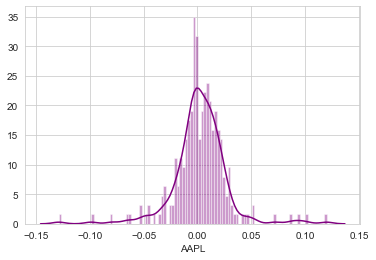

In [28]:
sns.distplot(closing_perct.AAPL.dropna(),bins=100,color='purple')

In [22]:
#for 95% level confidence 
closing_perct['AAPL'].quantile(0.05)

-0.03301109194900948

The 0.05 empirical quantile of daily returns is at -0.03. That means that with 95% confidence, our worst daily loss will not exceed 3%. If we have a 1 million dollar investment, our one-day 5% VaR is 0.03 * 1,000,000 = $30,000.

In [ ]:
#for google

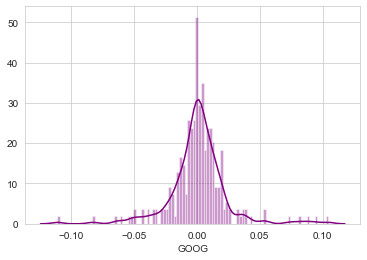

In [29]:
sns.distplot(closing_perct.GOOG.dropna(),bins=100,color='purple')

In [23]:
closing_perct['GOOG'].quantile(.05)

-0.03457167691969172

In [ ]:
#almost same as apple

# 2. Value at Risk using the Monte Carlo method

Using the Monte Carlo to run many trials with random market conditions, then we'll calculate portfolio losses for each trial. After this, we'll use the aggregation of all these simulations to establish how risky the stock is.

Let's start with a brief explanation of what we're going to do:

We will use the geometric Brownian motion (GBM), which is technically known as a Markov process. This means that the stock price follows a random walk and is consistent with (at the very least) the weak form of the efficient market hypothesis (EMH): past price information is already incorporated and the next price movement is "conditionally independent" of past price movements.

This means that the past information on the price of a stock is independent of where the stock price will be in the future, basically meaning, you can't perfectly predict the future solely based on the previous price of a stock.

The equation for geometric Browninan motion is given by the following equation:

ΔSS=μΔt+σϵΔt−−−√

Where S is the stock price, mu is the expected return (which we calculated earlier),sigma is the standard deviation of the returns, t is time, and epsilon is the random variable.

We can mulitply both sides by the stock price (S) to rearrange the formula and solve for the stock price.

ΔS=S(μΔt+σϵΔt−−−√)

Now we see that the change in the stock price is the current stock price multiplied by two terms. The first term is known as "drift", which is the average daily return multiplied by the change of time. The second term is known as "shock", for each tiem period the stock will "drift" and then experience a "shock" which will randomly push the stock price up or down. By simulating this series of steps of drift and shock thousands of times, we can begin to do a simulation of where we might expect the stock price to be.

For more info on the Monte Carlo method for stocks, check out the following link: http://www.investopedia.com/articles/07/montecarlo.asp

To demonstrate a basic Monte Carlo method, we will start with just a few simulations. First we'll define the variables we'll be using the Google DataFrame GOOG

In [30]:
# Set up our time horizon
days = 365

# Now our delta
dt = 1/days

# Now let's grab our mu (drift) from the expected return data we got for AAPL
mu = closing_perct.mean()['GOOG']

# Now let's grab the volatility of the stock from the std() of the average return
sigma = closing_perct.std()['GOOG']

In [31]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in range(1,days):
        
        # Calculate Schock
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

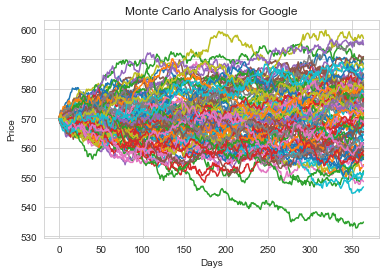

In [32]:
# Get start price from GOOG.head()
start_price = 569.85

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Google')

In [33]:
# Set a large numebr of runs
runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in range(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];

Now that we have our array of simulations, we can go ahead and plot a histogram ,as well as use qunatile to define our risk for this stock.

For more info on quantiles, check out this link: http://en.wikipedia.org/wiki/Quantile

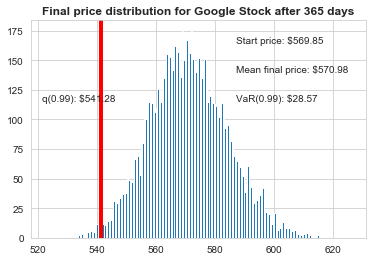

In [34]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for Google Stock after %s days" % days, weight='bold');

Awesome! Now we have looked at the 1% empirical quantile of the final price distribution to estimate the Value at Risk for the Google stock, which looks to be $28.57 for every investment of 569.85 (the price of one inital google stock).

This basically menas for every initial stock you purchase your putting about $28.57 at risk 99% of the time from our Monte Carlo Simulation.